<a href="https://colab.research.google.com/github/Dawoon-Jeong0523/Product-Science/blob/main/Embedding_Products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [ ]:
import pickle
import os
import json

import nltk
from nltk.corpus import stopwords
import re

import pandas as pd
import numpy as np
from collections import Counter

import warnings
from tqdm import tqdm

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download("wordnet")
stops=set(stopwords.words('english'))

In [ ]:
# 3.9.6.64bit
output_directory=r'/content/drive/MyDrive/Research/Product Science/Output'
data_directory=r'/content/drive/MyDrive/Research/Product Science/Data'

In [ ]:
year_list=[year for year in range(1994,2025)]

In [ ]:
class Product():
  def __init__(self,id,name,year,firm, Domains,SubDomains,char_names,chars):
    self.id=id # int
    self.name=name # str
    self.year=year # int
    self.firm=firm # str
    self.Domains=Domains # list
    self.SubDomains=SubDomains # Domain_SubDoamin: list
    self.chars_name = char_names # char_dictioanry: char
    self.chars=chars # char_dictioanry: index

    self.product_type=None

    self.vector= None
    self.vector_dim=None # dimensionality reduction
    self.taxon=None

    self.functional_modules=None
    self.functional_modules_2=None # 임시
    self.information_content=None
    self.innovativeness=None
    self.lineage=None

    self.ancestors=None
    self.ancestor=None
    self.descendant=None
    self.descendants=None

    self.temp_1=None
    self.temp_2=None

    self.optimal_n = None
    self.cluster_labels = None
    self.cluster_centers = None
    self.modularity = None

# Data Load

In [ ]:
# Data Load
with open(data_directory+'/Total_Data.json','r') as f:
  data=json.load(f)

In [ ]:
temp_year_list=[]
temp_other_pattern_list=[]

regex1 = re.compile(r'released \d\d\d\d')
regex2 = re.compile(r'\d\d\d\d')
temp_year_list=[]
temp_other_patten_list=[]
for name in data.keys():
  try:
    item=data[name]["Launch"]["Announced"][0]
    if regex1.search(item):
      year=int(regex1.search(item).group()[-4:])
    elif regex2.search(item):
      year=int(regex2.search(item).group())
    else:
      year=None
    data[name]["year"]=year
    temp_year_list.append(year)
  except:
    temp_other_pattern_list.append(data[name]["Launch"]["Announced"])

In [ ]:
data['Apple iPhone']

In [ ]:
# Assuming `data` is your dataset
delete_list = set(['т9', '-', '?', 'no', 'n/a', 'na', 'nо', 'or'])

Domain_SubDomain_set = set()
Domain_set = set()
char_set = set()
Name_set = set()
Firm_set = set()

temp_result_list=[]
for name in data.keys():
    if 'year' in data[name] and data[name]['year'] and int(data[name]['year']) in year_list:
        for Domain, SubDomains in data[name].items():
            temp_list = []
            if Domain not in ["Misc", "Launch","Demand"] and isinstance(SubDomains, dict):
                for SubDomain, items in SubDomains.items():
                    if items:
                        for item in items:
                            for char in item.split(','):
                                char = char.lower().strip()
                                if char and char not in delete_list:
                                    if char == 'au)':
                                        char = 'au'
                                    Name_set.add(name)
                                    Domain_set.add(Domain)
                                    char_set.add(char)
                                    Domain_SubDomain_set.add(f"{Domain}_{SubDomain}")
                                    Firm_set.add(name.split(' ')[0].strip())
                                    temp_result_list.append([Domain, f"{Domain}_{SubDomain}", char, name,name.split(' ')[0].strip()])

Domain_list = list(Domain_set)
Domain_SubDomain_list = list(Domain_SubDomain_set)
char_list = list(char_set)
Name_list = list(Name_set)
Firm_list = list(Firm_set)

# Domain == Camera has always no in char
len(Domain_list), len(Domain_SubDomain_list), len(char_list), len(Name_list), len(Firm_list)

In [ ]:
with open(data_directory+'/id2Domain.pkl','wb') as f:
  id2Domain = dict(zip([id for id in range(len(sorted(Domain_list)))] , sorted(Domain_list)))
  pickle.dump(id2Domain,f)

with open(data_directory+'/id2SubDomain.pkl','wb') as f:
  id2SubDomain=dict(zip([id for id in range(len(sorted(Domain_SubDomain_list)))],sorted(Domain_SubDomain_list)))
  pickle.dump(id2SubDomain,f)

with open(data_directory+'/id2Product.pkl','wb') as f:
  id2Product = dict(zip([id for id in range(len(sorted(Name_list)))] , sorted(Name_list)))
  pickle.dump(id2Product,f)

with open(data_directory+'/id2Firm.pkl','wb') as f:
  id2Firm = dict(zip([id for id in range(len(sorted(Firm_list)))] , sorted(Firm_list)))
  pickle.dump(id2Firm,f)

In [ ]:
char_dictionary_df=pd.DataFrame(temp_result_list)
char_dictionary_df.columns=['Domain','SubDomain','char',"Product",'Firm']
char_dictionary_df = char_dictionary_df[['Domain','SubDomain','char']]
char_dictionary_df.drop_duplicates(inplace=True)
char_dictionary_df.reset_index(inplace=True,drop=True)
char_dictionary_df.head()

In [ ]:
id2char = {}
for index, row in char_dictionary_df[['Domain','SubDomain','char']].iterrows():
    domain = row['Domain']
    subdomain = row['SubDomain']
    char = row['char']
    id2char[index] = [domain, subdomain, char]

In [ ]:
with open(data_directory+'/id2char.pkl','wb') as f:
  pickle.dump(id2char,f)

In [ ]:
df=pd.DataFrame(temp_result_list)
df.columns=['Domain','SubDomain','char','Product','Firm']
df.head()

In [ ]:
with open(data_directory+'/context_df.pkl','wb') as f:
  pickle.dump(df,f)

In [ ]:
char2id ={(value[0],value[1],value[2]):key for key,value in id2char.items()}

In [ ]:
Product2id = {value:key for key,value in id2Product.items()}

In [ ]:
Product_list = []
for i, name in tqdm(enumerate(df["Product"].unique())):
    if 'year' in data[name].keys():
        temp_year = data[name]['year']
        firm=name.split(' ')[0].strip()
        temp_df = df[df["Product"]==name]
        Domains = list(temp_df["Domain"])
        SubDomains = list(temp_df["SubDomain"])
        chars = list(temp_df["char"])
        temp_ids = []
        for row in temp_df.iterrows():
            temp_id = char2id[(row[1]["Domain"],row[1]["SubDomain"],row[1]["char"])]
            temp_ids.append(temp_id)
        product=Product(Product2id[name],name,temp_year,firm,Domains,SubDomains,chars,temp_ids)
        Product_list.append(product)
    else:
        print(name)

In [ ]:
with open(data_directory+f'/Products.pkl','wb') as f:
    pickle.dump(Product_list, f)

In [ ]:
with open(data_directory+f'/Products.pkl','rb') as f:
    Product_list = pickle.load(f)

In [ ]:
temp_products=[product for product in Product_list if product.year]
temp_min=min([product.year for product in temp_products])
temp_max=max([product.year for product in temp_products])

temp_value_list=[]
year_list=[year for year in range(temp_min,temp_max+1)]
for year in year_list:
  temp_value_list.append(len([product for product in temp_products if product.year==year]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set_theme(style="whitegrid", palette="colorblind")

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Creating the barplot
bars = ax.bar(year_list, temp_value_list, color=sns.color_palette("colorblind")[0], alpha=0.7)

# Customize the ticks and labels
ax.tick_params(axis="x", width=1, direction="in", labelsize=20, rotation=90)
ax.tick_params(axis="y", width=1, direction="in", labelsize=20)

# Adding text labels on bars
for i, b in enumerate(bars):
    ax.text(b.get_x() + b.get_width() * 0.5, b.get_height() + 1, format(temp_value_list[i], ",d"),
            ha='center', fontsize=15, fontweight="bold")

# Adding labels and lines
ax.set_xticks(year_list)
ax.set_xlabel("Year", fontsize=30)
ax.set_ylabel("Number of Products", fontsize=30)
ax.axvline(x=1994, color='red', linestyle='dotted', linewidth=2)
ax.axvline(x=2023, color='red', linestyle='dotted', linewidth=2)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set background color to white for a clean look
ax.set_facecolor('white')
fig.set_facecolor('white')

# Adjusting path as needed
output_directory = "./"
plt.savefig(f"{output_directory}/Product_year_histogram.jpg", dpi=600, transparent=False, bbox_inches="tight")


# Using Context around Product, consructing network

In [ ]:
# Load pickles

with open(data_directory+f'/id2Domain.pkl','rb') as f:
    id2Domain = pickle.load(f)
with open(data_directory+f'/id2Product.pkl','rb') as f:
    id2Product = pickle.load(f)
with open(data_directory+f'/id2SubDomain.pkl','rb') as f:
    id2SubDomain = pickle.load(f)
with open(data_directory+f'/id2char.pkl','rb') as f:
    id2char = pickle.load(f)
with open(data_directory+f'/Products.pkl','rb') as f:
    Product_list = pickle.load(f)
with open(data_directory+f'/id2Firm.pkl','rb') as f:
    id2Firm = pickle.load(f)
with open(data_directory+f'/context_df.pkl','rb') as f:
    context_df = pickle.load(f)

In [ ]:
len(id2Domain), len(id2SubDomain), len(id2Product), len(id2char), len(Product_list), len(id2Firm), len(context_df)

In [ ]:
context_df.head()

In [ ]:
Firm2id = {value:key for key, value in id2Firm.items()}
Domain2id = {value:key for key, value in id2Domain.items()}
SubDomain2id = {value:key for key, value in id2SubDomain.items()}
Product2id = {value:key for key, value in id2Product.items()}

In [ ]:
char2id = {(value[0],value[1],value[2]):key for key, value in id2char.items()}

In [ ]:
# Using this one (241213)

import networkx as nx

Hetero_G = nx.DiGraph()

for i in id2SubDomain.keys():
    Hetero_G.add_node('subdomain_'+str(i),type='subdomain')
for i in id2char.keys():
    Hetero_G.add_node('char_'+str(i),type='char')
for i in id2Product.keys():
    Hetero_G.add_node('product_'+str(i),type='product')
for i in id2Firm.keys():
    Hetero_G.add_node('firm_'+str(i),type='firm')

for i, row in context_df.iterrows():
    temp_product = 'product_%s'%str(Product2id[row['Product']] )
    temp_char = 'char_%s'%str(char2id[(row['Domain'],row['SubDomain'],row['char'])])
    temp_subdomain = 'subdomain_%s'%str(SubDomain2id[row['SubDomain']] )
    temp_firm = 'firm_%s'%str(Firm2id[row['Firm']] )

    Hetero_G.add_edge(temp_firm,temp_product,type='produce')
    Hetero_G.add_edge(temp_product,temp_subdomain,type='function')
    Hetero_G.add_edge(temp_subdomain,temp_char,type='tech')
    Hetero_G.add_edge(temp_char,temp_product,type='has')


In [ ]:
print("Graph Summary")
print(f"Number of nodes: {Hetero_G.number_of_nodes()}")
print(f"Number of edges: {Hetero_G.number_of_edges()}")
print("\nNode types:")
node_types = {}
for _, data in Hetero_G.nodes(data=True):
    node_type = data.get('type', 'unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1
for node_type, count in node_types.items():
    print(f"{node_type}: {count}")

print("\nEdge types:")
edge_types = {}
for _, _, data in Hetero_G.edges(data=True):
    edge_type = data.get('type', 'unknown')
    edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
for edge_type, count in edge_types.items():
    print(f"{edge_type}: {count}")


# Random walks in the network

In [ ]:
import random

def random_walk(G, start_node, walk_length):
    walk = [start_node]
    current_node = start_node

    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current_node))
        if len(neighbors) == 0:
            break
        current_node = random.choice(neighbors)
        walk.append(current_node)
    return walk

In [ ]:
num_walks = 40

walks = []
for node in tqdm(Hetero_G.nodes()):
    for n in range(0,num_walks):
        walk = random_walk(Hetero_G, node, 20)
        walks.append(walk)

In [ ]:
# 40 num walks, 20 walk length

with open(data_directory+f'/walks_40_20.pkl','wb') as f:
    pickle.dump(walks, f)

# Embedding

In [ ]:
with open(data_directory+f'/walks_40_20.pkl','rb') as f:
  walks = pickle.load(f)

In [ ]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# walks 40 20
model = Word2Vec(walks, vector_size=64, window=5, min_count=0, workers=2, sg=1)

In [ ]:
import os

model_directory = os.path.join(data_directory, "Model1")
os.makedirs(model_directory, exist_ok=True)
model.save(model_directory+"/word2vec_model_250120.bin")

# Load Embedding Model

In [ ]:
from gensim.models import Word2Vec

model_directory = os.path.join(data_directory, "Model1")
model = Word2Vec.load(model_directory+"/word2vec_model_250120.bin")

In [ ]:
similar_words = model.wv.most_similar("char_5888", topn=5)
similar_words

# Embedding Vector

In [ ]:
X = model.wv.vectors
X.shape

In [ ]:
model.wv.key_to_index

In [ ]:
Productid2vector = {}
Charid2vector = {}
SubDomainid2vector = {}
Firm2id2vector = {}

for key in tqdm(model.wv.key_to_index):
    index = model.wv.key_to_index[key]
    if 'char' in key:
        Charid2vector[int(key.split('_')[-1])]=X[index]
    elif 'product' in key:
        Productid2vector[int(key.split('_')[-1])]=X[index]
    elif 'subdomain' in key:
        SubDomainid2vector[int(key.split('_')[-1])]=X[index]
    elif 'firm' in key:
        Firm2id2vector[int(key.split('_')[-1])]=X[index]
    else:
        print(key)

In [ ]:
with open(model_directory+f'/Charid2vector.pkl','wb') as f:
    pickle.dump(Charid2vector,f)
with open(model_directory+f'/Productid2vector.pkl','wb') as f:
    pickle.dump(Productid2vector,f)
with open(model_directory+f'/SubDomainid2vector.pkl','wb') as f:
    pickle.dump(SubDomainid2vector,f)
with open(model_directory+f'/Firm2id2vector.pkl','wb') as f:
    pickle.dump(Firm2id2vector,f)

## Visualization

In [ ]:
def euclidean_distance(A,B):
  return np.sqrt(np.sum((A-B)**2))

import matplotlib.colors as mcolors
colors=list(mcolors.BASE_COLORS)
colors+=list(mcolors.CSS4_COLORS)[10:]

In [ ]:
with open(model_directory+f'/Charid2vector.pkl','rb') as f:
    Charid2vector = pickle.load(f)
with open(model_directory+f'/Productid2vector.pkl','rb') as f:
    Productid2vector = pickle.load(f)
with open(model_directory+f'/SubDomainid2vector.pkl','rb') as f:
    SubDomainid2vector = pickle.load(f)
with open(model_directory+f'/Firm2id2vector.pkl','rb') as f:
    Firmid2vector = pickle.load(f)

with open(data_directory+f'/id2Domain.pkl','rb') as f:
    id2Domain = pickle.load(f)
with open(data_directory+f'/id2Product.pkl','rb') as f:
    id2Product = pickle.load(f)
with open(data_directory+f'/id2SubDomain.pkl','rb') as f:
    id2SubDomain = pickle.load(f)
with open(data_directory+f'/id2char.pkl','rb') as f:
    id2char = pickle.load(f)
with open(data_directory+f'/Products.pkl','rb') as f:
    Product_list = pickle.load(f)
with open(data_directory+f'/id2Firm.pkl','rb') as f:
    id2Firm = pickle.load(f)
with open(data_directory+f'/context_df.pkl','rb') as f:
    context_df = pickle.load(f)

In [ ]:
Firm2id = {value:key for key, value in id2Firm.items()}
Domain2id = {value:key for key, value in id2Domain.items()}
SubDomain2id = {value:key for key, value in id2SubDomain.items()}
Product2id = {value:key for key, value in id2Product.items()}
char2id = {(value[0],value[1],value[2]):key for key, value in id2char.items()}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

np.random.seed(42)

In [ ]:
temp_list = list(Firmid2vector.keys())
temp_list = sorted(temp_list)

first_key = 0
Firm_X = np.array([Firmid2vector[first_key]])
for i in tqdm(temp_list[1:]):
    Firm_X = np.concatenate((Firm_X, [Firmid2vector[i]]), axis=0)

In [ ]:
temp_list = list(SubDomainid2vector.keys())
temp_list = sorted(temp_list)

first_key = 0
SubDomain_X = np.array([SubDomainid2vector[first_key]])
for i in tqdm(temp_list[1:]):
    SubDomain_X = np.concatenate((SubDomain_X, [SubDomainid2vector[i]]), axis=0)

In [ ]:
temp_list = list(Productid2vector.keys())
temp_list = sorted(temp_list)

first_key = 0
Product_X = np.array([Productid2vector[first_key]])
for i in tqdm(temp_list[1:]):
    Product_X = np.concatenate((Product_X, [Productid2vector[i]]), axis=0)

In [ ]:
temp_list = list(Charid2vector.keys())
temp_list = sorted(temp_list)

first_key = 0
Char_X = np.array([Charid2vector[first_key]])
for i in tqdm(temp_list[1:]):
    Char_X = np.concatenate((Char_X, [Charid2vector[i]]), axis=0)

In [ ]:
X.shape

In [ ]:
Firm_X.shape, SubDomain_X.shape, Product_X.shape, Char_X.shape

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = reducer.fit_transform(X)
with open(model_directory + '/X_umap_3d.pkl', 'wb') as f:
  pickle.dump(X_umap_3d, f)

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=50,        # Larger neighborhood for global structure
    min_dist=0.2,         # Tighter clustering
    #metric='cosine',       # Use cosine distance
    random_state=42,
    spread=3,            # Increase spread for better separation
    learning_rate=0.5      # Slower optimization for smoother results
)

X_umap_2d = reducer.fit_transform(X)
with open(model_directory + '/X_umap_2d.pkl', 'wb') as f:
  pickle.dump(X_umap_2d, f)

In [ ]:
firm_index = [model.wv.key_to_index[item] for item in model.wv.key_to_index.keys() if 'firm' in item]
char_index = [model.wv.key_to_index[item] for item in model.wv.key_to_index.keys() if 'char' in item]
subdomain_index = [model.wv.key_to_index[item] for item in model.wv.key_to_index.keys() if 'subdomain' in item]
product_index = [model.wv.key_to_index[item] for item in model.wv.key_to_index.keys() if 'product' in item]

color_list = ['red', 'blue', 'green', 'purple']

In [ ]:
import matplotlib.colors as mcolors
colors=list(mcolors.BASE_COLORS)
colors+=list(mcolors.CSS4_COLORS)[10:]

In [ ]:
colors.remove('w')
Domain_color_dict = {value:colors[key] for key,value in id2Domain.items()}

In [ ]:
charid2vectorid = {int(item.split('_')[1]): model.wv.key_to_index[item] for item in model.wv.key_to_index.keys() if 'char' in item}

In [ ]:
color_list = []

for row in context_df.iterrows():
    color = Domain_color_dict[row[1]["Domain"]]
    color_list.append(color)

context_df["color"] = color_list
context_df['vector_id'] = context_df.index.map(charid2vectorid)

In [ ]:
with open(model_directory+f'/context_df_w vector_id.pkl','wb') as f:
    pickle.dump(context_df,f)

In [ ]:
temp_context_df = context_df.copy()
temp_context_df.dropna(inplace=True)
temp_context_df.reset_index(inplace=True,drop=True)

In [ ]:
from collections import Counter

temp_firms = [product.firm for product in Product_list]
major_firms = [x[0] for x in Counter(temp_firms).most_common(9)] + ['Apple']

Firm_color_dict = {firm:colors[key] for key,firm in enumerate(major_firms)}
Firm_color_dict

In [ ]:
with open(model_directory + '/X_umap_2d.pkl', 'rb') as f:
  X_umap_2d = pickle.load(f)
with open(model_directory + '/X_umap_3d.pkl', 'rb') as f:
  X_umap_3d = pickle.load(f)

In [ ]:
X_firm = X_umap_3d[firm_index,:]
X_char = X_umap_3d[char_index,:]
X_subdomain = X_umap_3d[subdomain_index,:]
X_product = X_umap_3d[product_index,:]

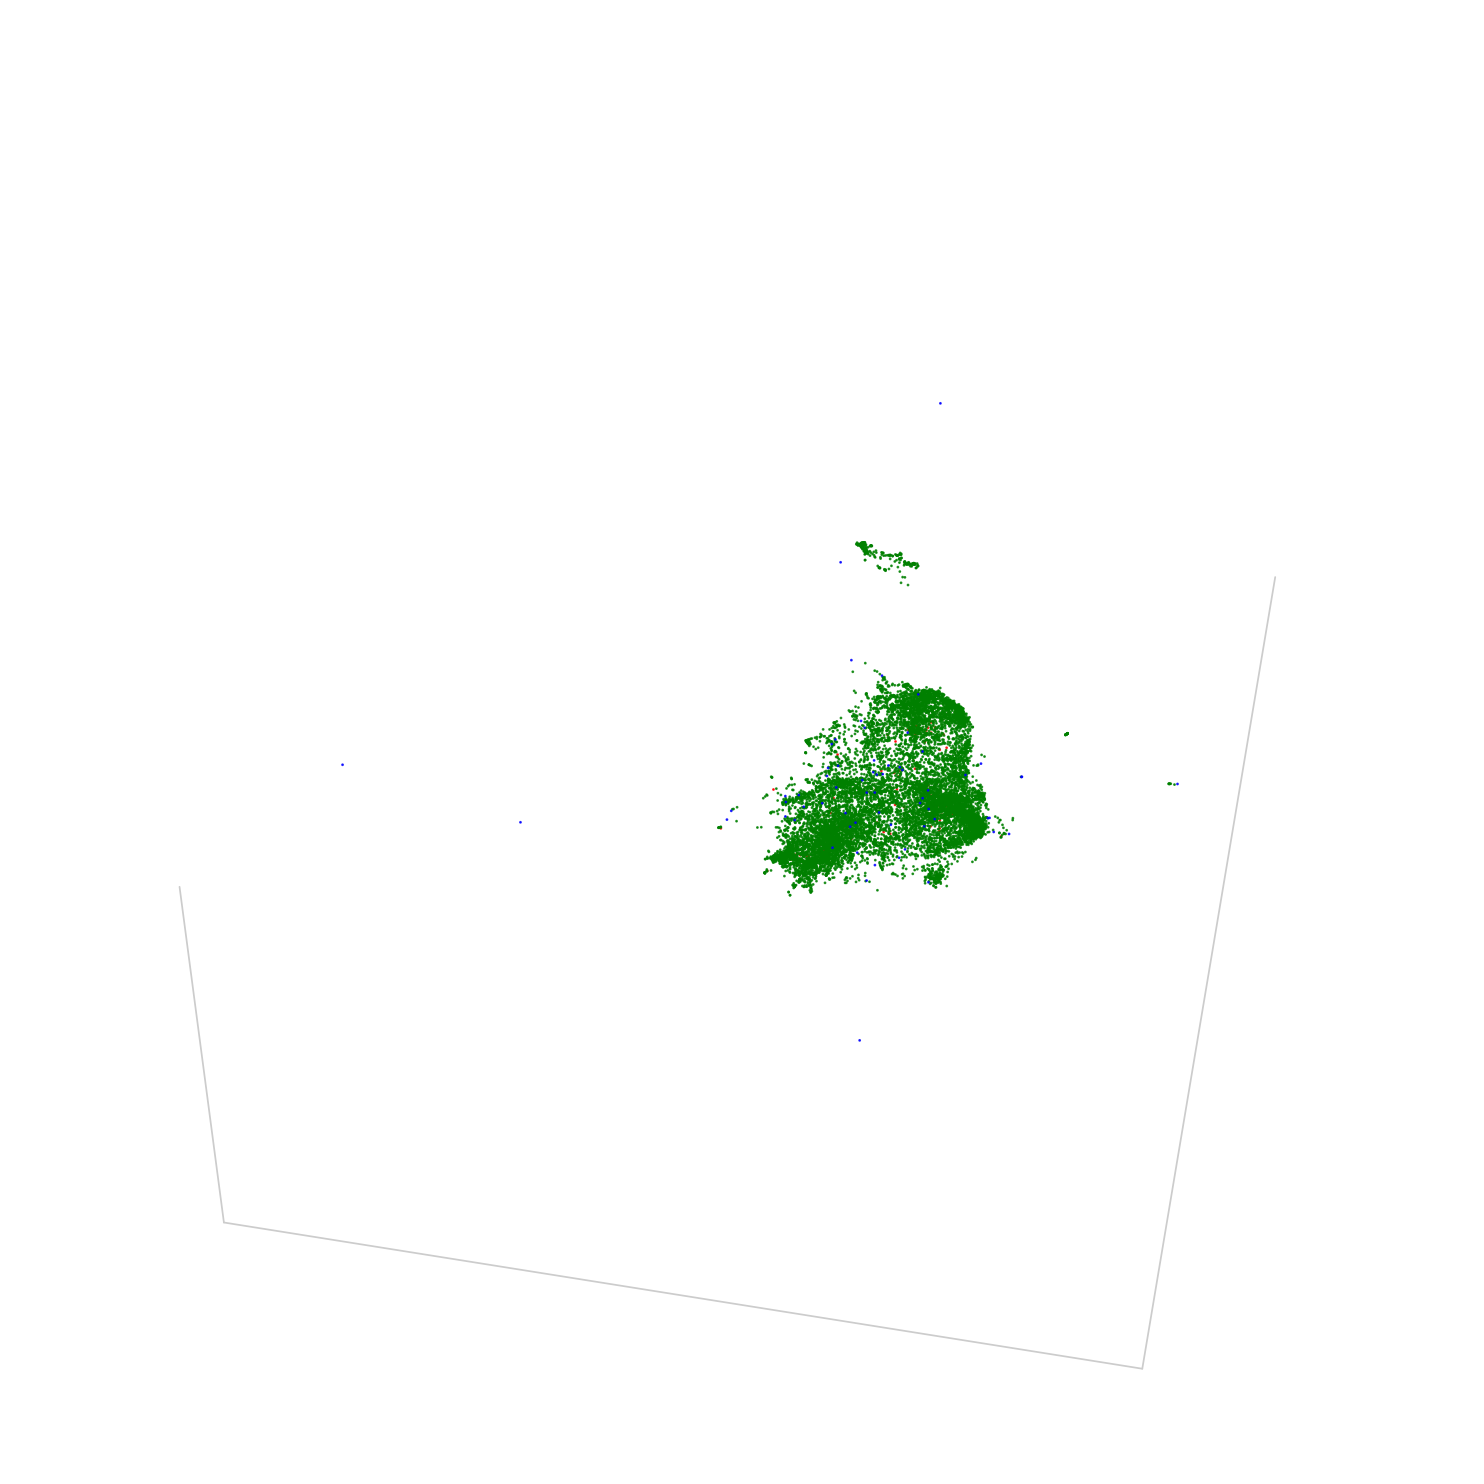

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set_theme(style="whitegrid", palette="colorblind")

# Create a 3D plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

#ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
#               color='grey', alpha=0.01, s=50)  # Adjust transparency and size


#index_list = [firm_index, char_index, subdomain_index, product_index]
index_list = [firm_index, subdomain_index, product_index]

for i, index in enumerate(index_list):
    if i == 0:
        color = 'red'
    elif i == 1:
        color = 'blue'
    elif i == 2:
        color = 'green'
    else:
        color = 'purple'
    ax.scatter(X_umap_3d[index, 0], X_umap_3d[index, 1], X_umap_3d[index, 2],
               color=color, alpha=0.8, s=1)  # Adjust transparency and size

# Remove 3D axis panes and gridlines
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')

# Remove ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

# Customize the view
ax.set_xticks([])
ax.set_yticks([])

# Set viewing angle
ax.view_init(elev=60, azim=10)

# Add legend
#ax.legend(fontsize=30, bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.legend(fontsize=50, loc='upper left')

# Final layout and save
plt.tight_layout()
plt.savefig(model_directory + '/Umap_3D_Domain.jpg', bbox_inches="tight",dpi = 600)
plt.savefig(model_directory + '/Umap_3D_Domain.pdf', bbox_inches="tight",dpi = 600)


In [37]:
len(firm_index), len(char_index), len(subdomain_index), len(product_index)

(121, 41501, 64, 12691)

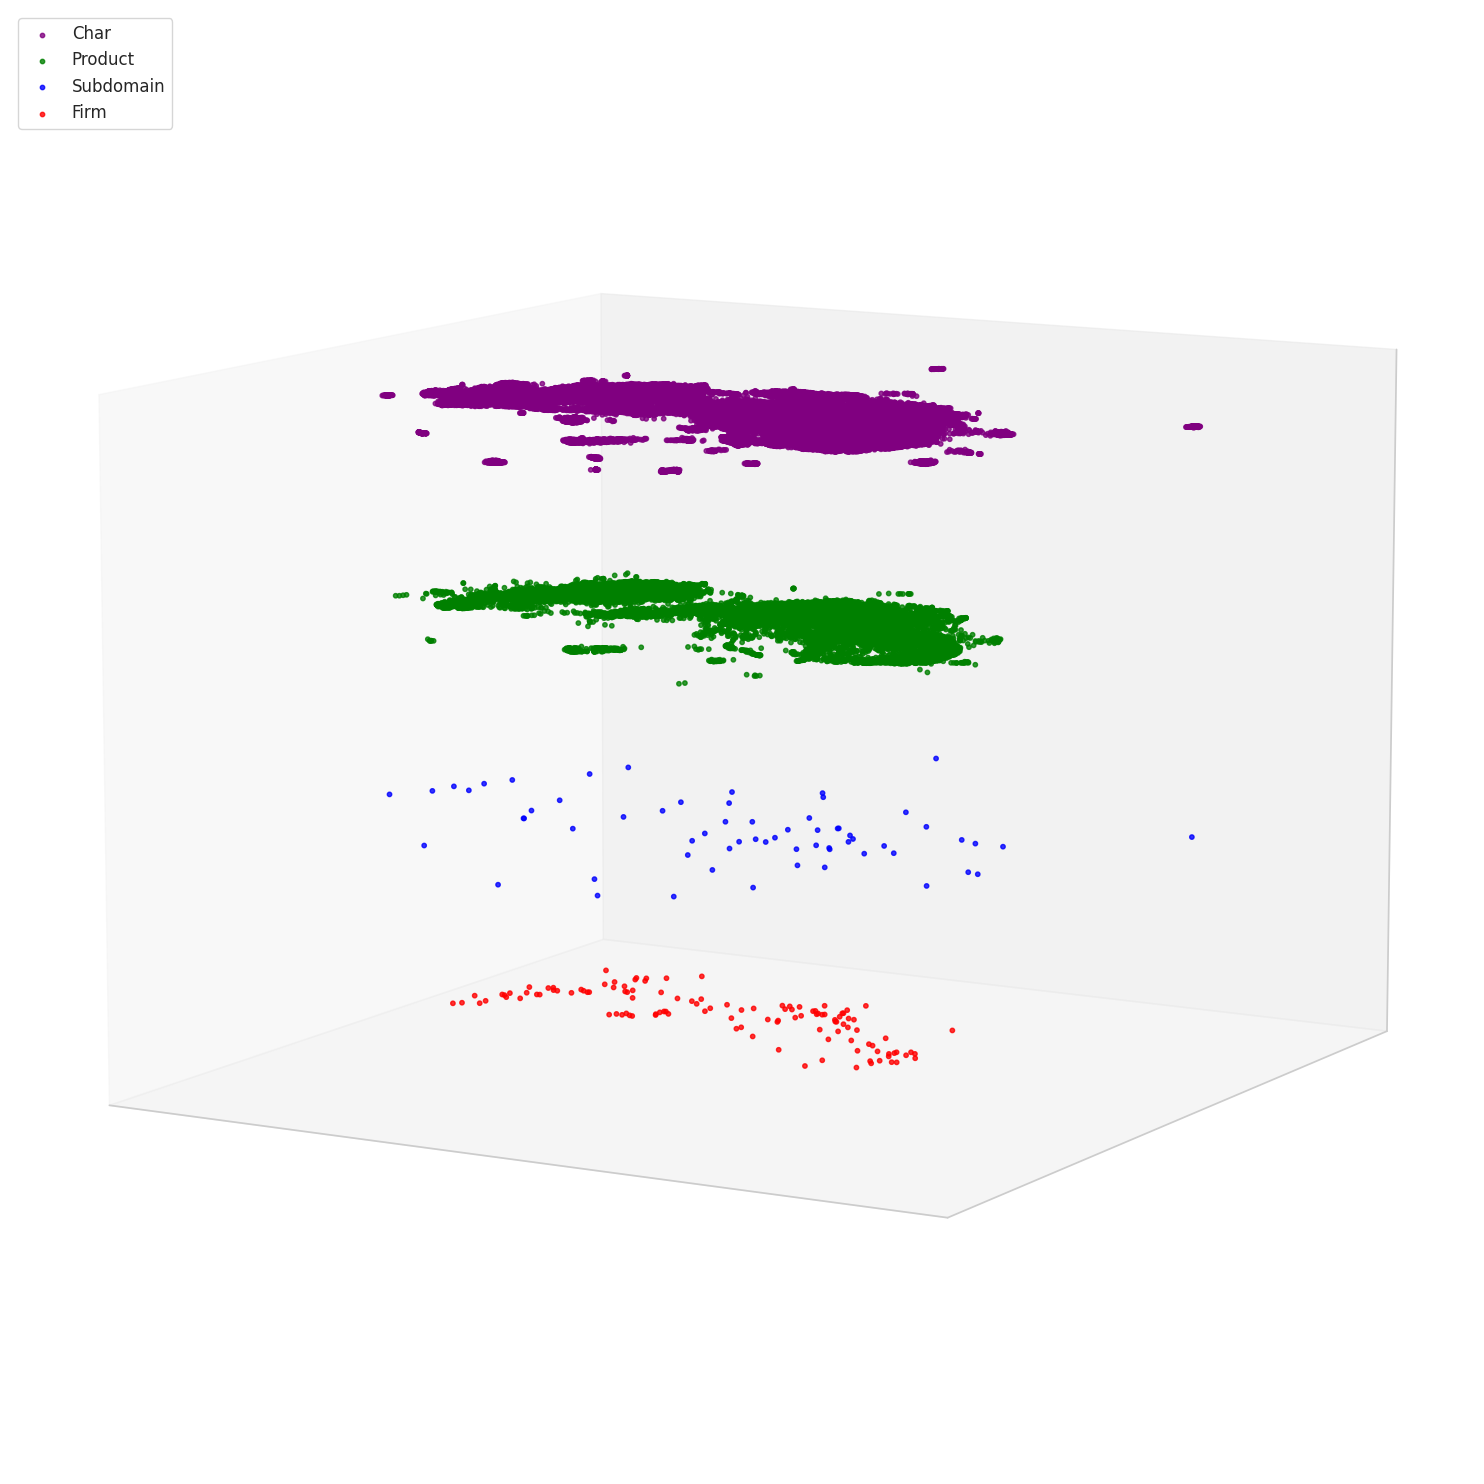

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Set the seaborn style
sns.set_theme(style="whitegrid", palette="colorblind")

# Create a 3D plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Define the z-layers for each category
z_layers = {
    'char': 3,
    'product': 2,
    'subdomain': 1,
    'firm': 0
}

# Define categories and their respective indices
categories = {
    'char': char_index,
    'product': product_index,
    'subdomain': subdomain_index,
    'firm': firm_index
}

# Define colors for each layer
colors = {
    'char': 'purple',
    'product': 'green',
    'subdomain': 'blue',
    'firm': 'red'
}

# Plot scatter points for each layer
for category, z in z_layers.items():
    index = categories[category]
    ax.scatter(
        X_umap_2d[index, 0],  # x-coordinates
        X_umap_2d[index, 1],  # y-coordinates
        z,                    # z-coordinates (constant for the layer)
        color=colors[category],
        alpha=0.8,            # Adjust transparency
        s=10,                 # Adjust size
        label=category.capitalize()
    )

# Customize the 3D view
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.grid(False)
ax.view_init(elev=10, azim=120)  # Customize the elevation and azimuth angles

# Add a legend
ax.legend(fontsize=12, loc='upper left')

# Final layout and save
plt.tight_layout()
plt.savefig(model_directory + '/Umap_3d_Domain.jpg', bbox_inches="tight", dpi=600)
plt.savefig(model_directory + '/Umap_3d_Domain.pdf', bbox_inches="tight", dpi=600)
plt.show()


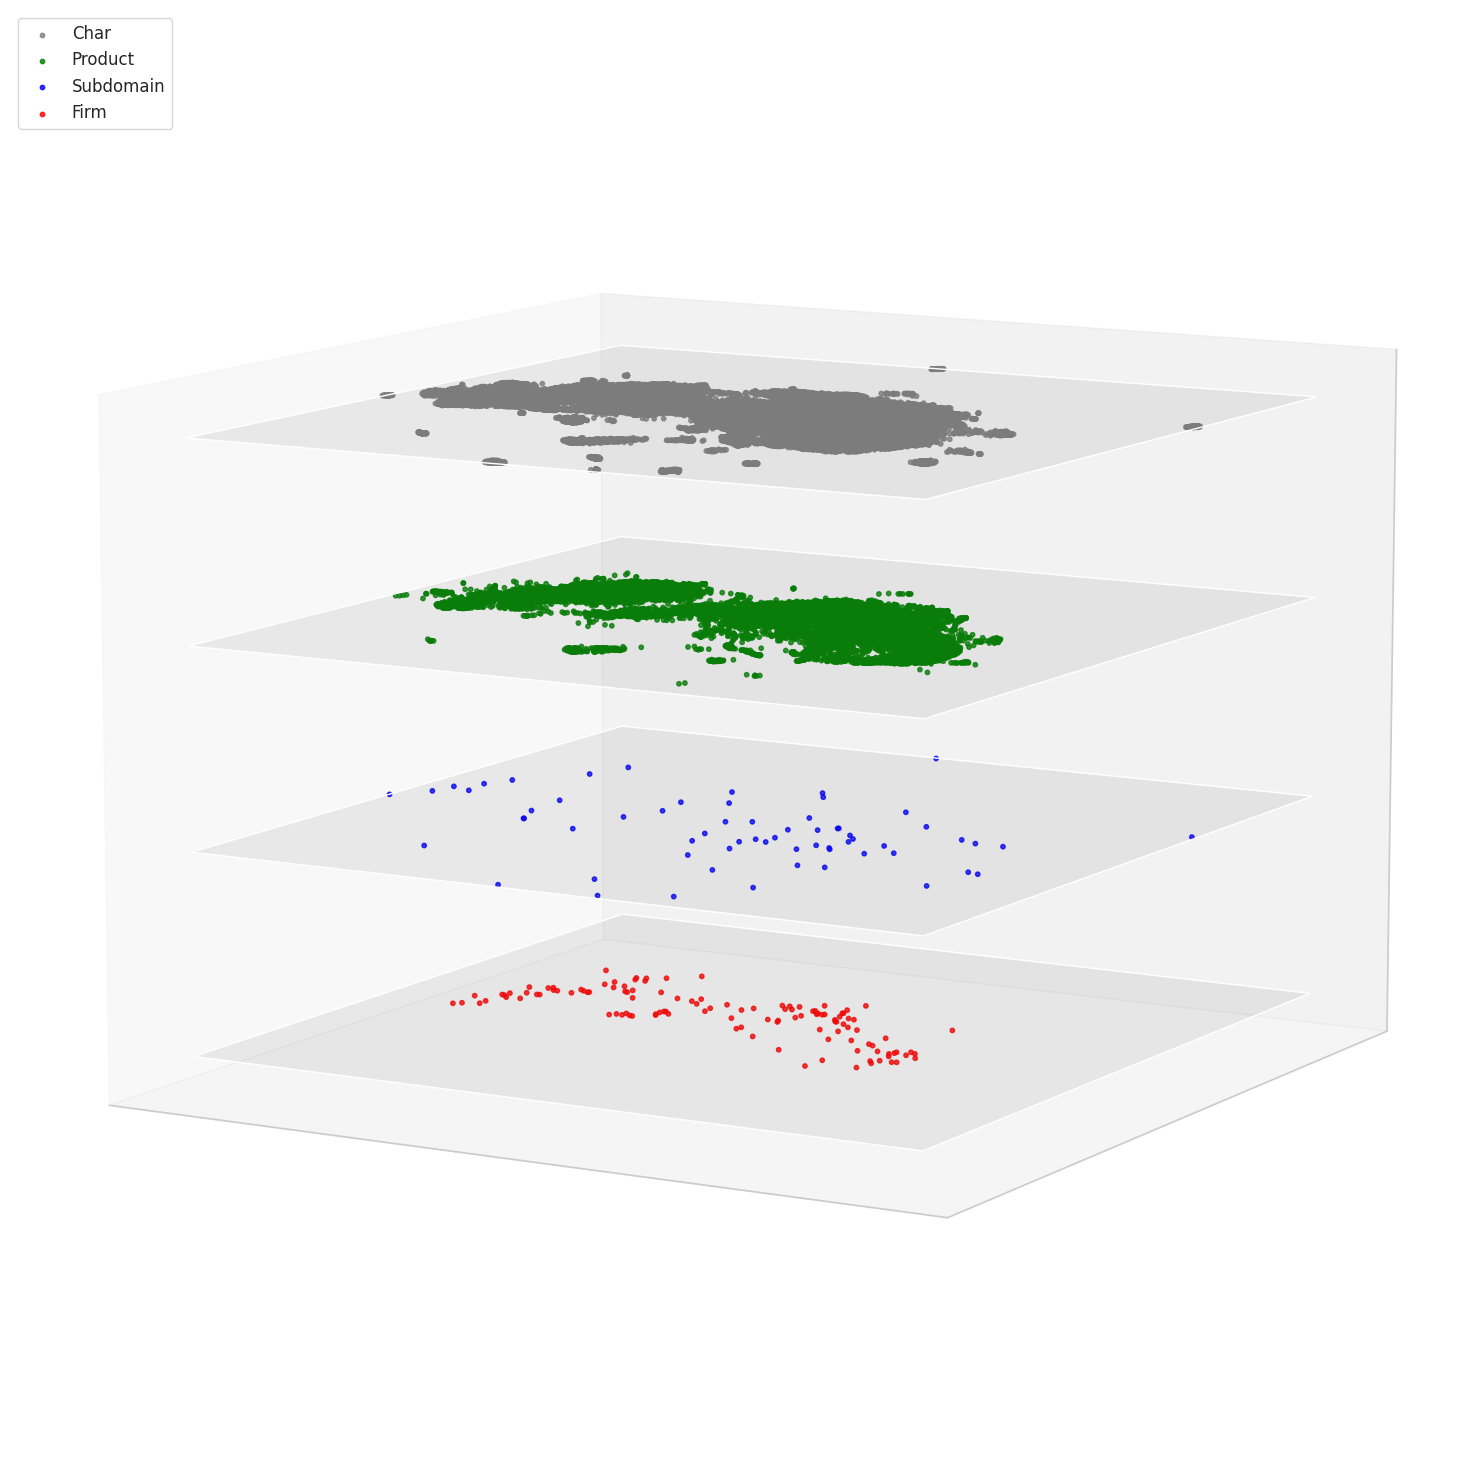

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Set the seaborn style
sns.set_theme(style="whitegrid", palette="colorblind")

# Create a 3D plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Define the z-layers for each category
z_layers = {
    'char': 3,
    'product': 2,
    'subdomain': 1,
    'firm': 0
}

# Define categories and their respective indices
categories = {
    'char': char_index,
    'product': product_index,
    'subdomain': subdomain_index,
    'firm': firm_index
}

# Define colors for each layer
colors = {
    'char': 'grey',
    'product': 'green',
    'subdomain': 'blue',
    'firm': 'red'
}

# Add grid planes for each layer
for z in z_layers.values():
    x_min, x_max = np.min(X_umap_2d[:, 0]), np.max(X_umap_2d[:, 0])
    y_min, y_max = np.min(X_umap_2d[:, 1]), np.max(X_umap_2d[:, 1])
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
    z_grid = np.full_like(x_grid, z)
    ax.plot_surface(
        x_grid, y_grid, z_grid,
        color='grey', alpha=0.1, rstride=100, cstride=100  # Transparent grid
    )

# Plot scatter points for each layer
for category, z in z_layers.items():
    index = categories[category]
    ax.scatter(
        X_umap_2d[index, 0],  # x-coordinates
        X_umap_2d[index, 1],  # y-coordinates
        z,                    # z-coordinates (constant for the layer)
        color=colors[category],
        alpha=0.8,            # Adjust transparency
        s=10,                 # Adjust size
        label=category.capitalize()
    )

# Customize the 3D view
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.grid(False)
ax.view_init(elev=10, azim=120)  # Customize the elevation and azimuth angles

# Add a legend
ax.legend(fontsize=12, loc='upper left')

# Final layout and save
plt.tight_layout()
plt.savefig(model_directory + '/Umap_3d_Domain_with_grids.jpg', bbox_inches="tight", dpi=600)
plt.savefig(model_directory + '/Umap_3d_Domain_with_grids.pdf', bbox_inches="tight", dpi=600)
plt.show()


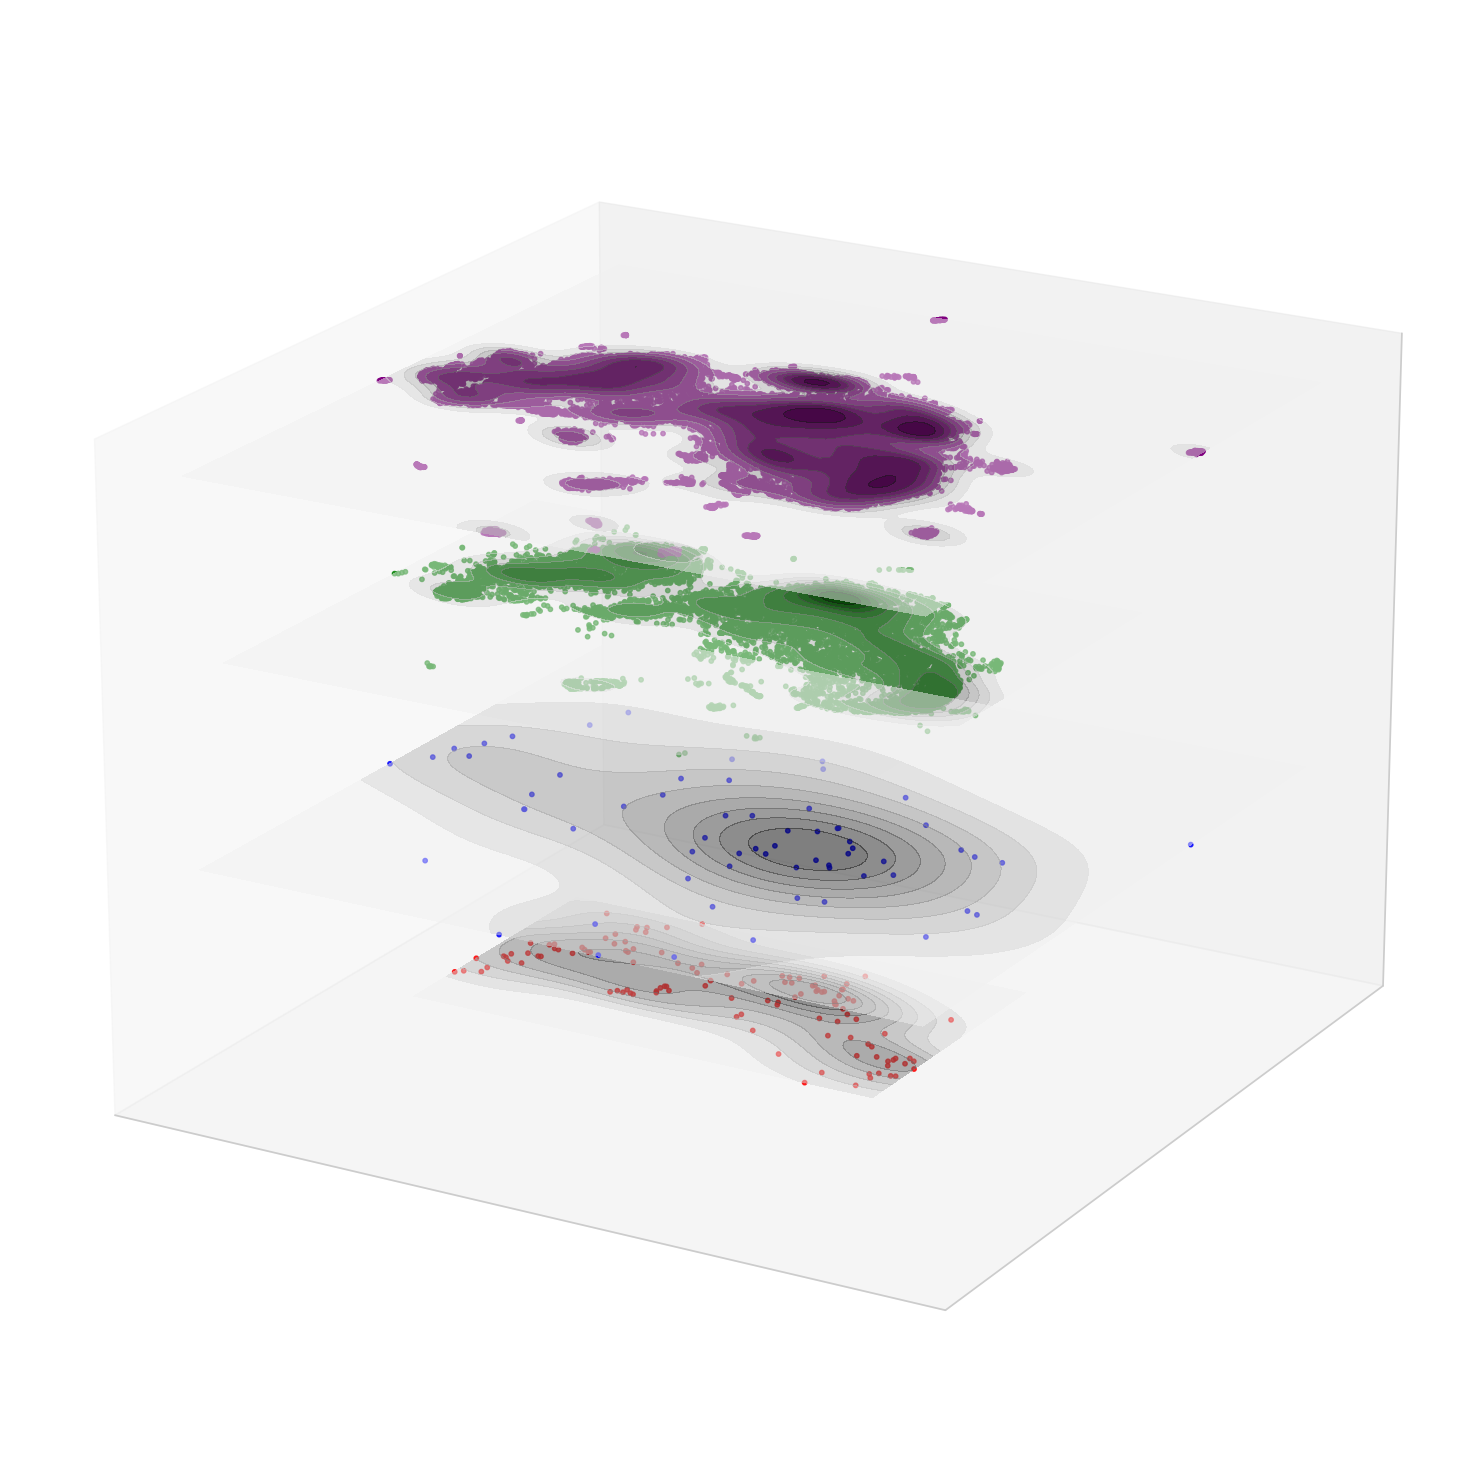

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Set the seaborn style
sns.set_theme(style="whitegrid", palette="colorblind")

# Create a 3D plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Define the z-layers for each category
z_layers = {
    'char': 3,
    'product': 2,
    'subdomain': 1,
    'firm': 0
}

# Define categories and their respective indices
categories = {
    'char': char_index,
    'product': product_index,
    'subdomain': subdomain_index,
    'firm': firm_index
}

# Define colors for each layer
colors = {
    'char': 'purple',
    'product': 'green',
    'subdomain': 'blue',
    'firm': 'red'
}

# Plot scatter points and contour plot for each layer
for category, z in z_layers.items():
    index = categories[category]
    x_data = X_umap_2d[index, 0]
    y_data = X_umap_2d[index, 1]

    # Scatter plot
    ax.scatter(
        x_data, y_data, np.full_like(x_data, z),  # z-coordinates are constant
        color=colors[category],
        alpha=0.8,
        s=10,
        label=f"{category.capitalize()} Scatter"
    )

    # Generate contour plot for the layer
    x_grid, y_grid = np.meshgrid(
        np.linspace(np.min(x_data), np.max(x_data), 100),
        np.linspace(np.min(y_data), np.max(y_data), 100)
    )
    # Kernel Density Estimate for contours
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(np.vstack([x_data, y_data]))
    z_density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # Add the contour plot to the 3D scatter
    levels = np.linspace(z_density.min(), z_density.max(), 10)  # Generate 10 evenly spaced levels
    ax.contourf(
        x_grid, y_grid, z_density,  # Use x, y grid and density values
        zdir='z',  # Project onto the z-axis
        offset=z,  # Offset the contour on the z-axis
        cmap='binary', alpha=0.5,  # Colormap and transparency
        levels=levels  # Ensure levels are increasing
    )

# Customize the 3D view
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.grid(False)
ax.view_init(elev=20, azim=120)  # Customize the elevation and azimuth angles

# Add a legend
#ax.legend(fontsize=12, loc='upper left')

# Final layout and save
plt.tight_layout()
plt.savefig(model_directory + '/Umap_3d_Domain_with_contour.jpg', bbox_inches="tight", dpi=600)
plt.savefig(model_directory + '/Umap_3d_Domain_with_contour.pdf', bbox_inches="tight", dpi=600)
plt.show()
